# In this notbeook threse is an application of the CrossCorrelation module



In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import glob
import os
from skimage import io
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.animation as animation
from IPython.display import HTML
import pickle

import sys
sys.path.insert(0,'/media/DATA/jbonato/astro_segm/Astro3S/modules/')
from CC import main_CC,clean_outer_pixel
from get_traces import Extr_miniROI,get_signal,get_signals
from gui_results import layout


MAX_ROI_AREA_PROC=60
MU_PX = 1

## Rocording loading


In [2]:
device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
num = '2'
query = '{0:0>3}'.format(num)
dict_im = pickle.load( open( "inference_ex.pkl", "rb" ))
stack_o = dict_im['t-series_'+query]
mask_sp = dict_im['Single_cell_mask_'+query]
T,N,M = stack_o.shape
###
print('t-series loaded, dim: ',stack_o.shape)
print('roi loaded, dim: ',mask_sp.shape)


#### remove outer pixels
mask_sp = clean_outer_pixel(mask_sp,num_pix=4)


t-series loaded, dim:  (550, 256, 256)
roi loaded, dim:  (5, 256, 256, 2)


In [3]:
plot_video = False
if plot_video:
    im_list = []
    for i in range(100):
        im_list.append(stack_o[i,:,:])

    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(i, animated=True)] for i in im_list]

    ani = animation.ArtistAnimation(fig, ims, interval=1, repeat_delay=1000, blit=True)

    HTML(ani.to_jshtml())

    


In [4]:
r = 60
mask_single_corr,mask_ROI = main_CC(stack_o,mask_sp,r,device=device1)

////////// CORR ANALysis //////////
True
correlation error = 0.048380 with threshold = 0.850000
Reduction finish


In [5]:
###clean CC for retrieving signals
def cleanCC_for_signals(dict_ROI,mask_ROI,MAX_ROI_AREA_PROC):
    _,N,M,_ = mask_ROI.shape
    for key in dict_ROI.keys():
        coord = dict_ROI[key]
        mask_ROI[:,coord[0],coord[1],2]=0
    mask_ROI_clean = np.zeros_like(mask_ROI)
    mask_ROI_clean[:,:,:,:2] = mask_ROI[:,:,:,:2]
    
    mask_ROI_inter_region = np.zeros((N,M))
    
    for i in range(mask_ROI.shape[0]):
        num,comp = cv2.connectedComponents(mask_ROI[i,:,:,2].astype(np.uint8))
        for k in range(1,num):
            pt = np.where(comp==k)
            if pt[0].shape[0]>=(MAX_ROI_AREA_PROC)//2:
                mask_ROI_clean[i,pt[0],pt[1],2]=1
    ### Intersection regions
    mask_ROI_inter_region = np.sum(mask_ROI_clean[:,:,:,2],axis=0)
    mask_ROI_inter_region[mask_ROI_inter_region<=1]=0
    
    for i in range(mask_ROI.shape[0]):
        for j in range(i+1,mask_ROI.shape[0]):
            mask_ROI_clean[i,:,:,2]-=mask_ROI_clean[j,:,:,2]
    
    mask_ROI_clean[mask_ROI_clean<0]=0
    
    return mask_ROI_clean,mask_ROI_inter_region

####
mask_ROI_new,intersection = cleanCC_for_signals(dict_im['ROI_'+query],mask_ROI,MAX_ROI_AREA_PROC)


In [6]:
print("ROI NUM",mask_ROI.shape[0])
dict_roi={}
dict_traces={}
dict_roi_num={}
for s_roi_num in range(mask_ROI.shape[0]):
    print(50*'%','Extracting cell:',s_roi_num)
    constr_split_roi = Extr_miniROI(MAX_ROI_AREA_PROC,MU_PX,mask_ROI[s_roi_num,:,:,2],mask_ROI[s_roi_num,:,:,1],True,dilate_ROI=0)
    arr_out_CC = constr_split_roi.get_miniROI()
    if  s_roi_num==0:
        list_out=arr_out_CC
    else:
        list_out = np.dstack((list_out,arr_out_CC))
    name = str(s_roi_num)
    dict_roi_num['Num_CC_'+f'{name:0>3}']=arr_out_CC.shape[2]
    for area_num in range(arr_out_CC.shape[2]):
        name_area = str(area_num)
        dict_roi['CC_'+f'{name:0>3}'+'_'+f'{name_area:0>3}'] = np.where(arr_out_CC[:,:,area_num]==1)
        dict_traces['CC_'+f'{name:0>3}'+'_'+f'{name_area:0>3}']  = get_signal(arr_out_CC[:,:,area_num],dict_im['t-series_'+query])
    print('Extraction: done')

dict_im['Signals_extr_'+query].update(dict_traces) 
dict_im['ROI_'+query].update(dict_roi)

# #### for Visualization purposes
list_out = np.dstack((list_out,dict_im['Final_Mask_'+query][:,:,1:]))
dict_im['Final_Mask_fraction_'+query] = list_out
dict_im['Num_CC_'+query] = dict_roi_num
# #### save dict
# pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

ROI NUM 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 30
mat_out (30, 256, 256)
check size (30, 256, 256)
ratio 0.05 0
ratio 31.716666666666665 31
ratio 0.23333333333333334 0
ratio 0.03333333333333333 0
ratio 3.5 3
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
ratio 5.283333333333333 5
ratio 0.016666666666666666 0
ratio 0.16666666666666666 0
ratio 0.016666666666666666 0
ratio 0.1 0
ratio 0.03333333333333333 0
ratio 0.08333333333333333 0
ratio 0.05 0
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
ratio 0.11666666666666667 0
ratio 0.08333333333333333 0
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
ratio 0.03333333333333333 0
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
ratio 0.05 0
ratio 1.1833333333333333 1
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
ratio 0.016666666666666666 0
SPLIT DONE (256, 256, 67)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

## visualization

In [10]:
cell = [0,1,2,4,5]

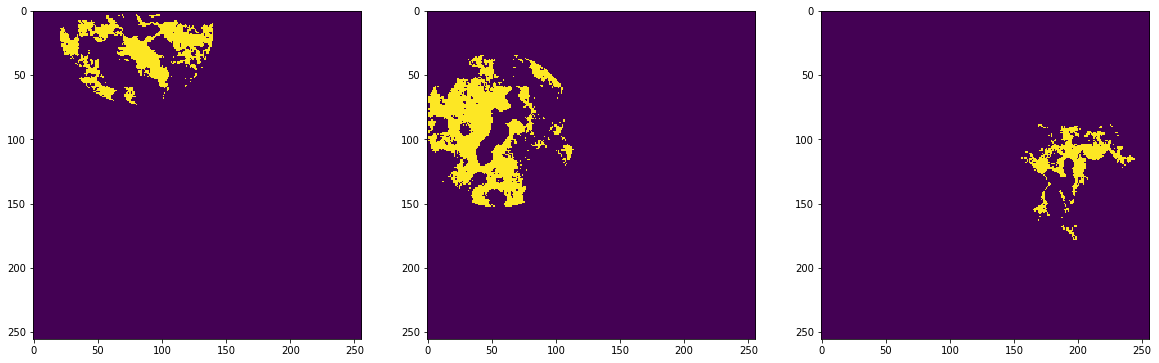

In [11]:
fig,[ax1,ax2,ax3] =plt.subplots(figsize=(20,20),ncols=3,nrows=1)
for j,a in zip(cell,[ax1,ax2,ax3]):
    a.imshow(mask_ROI[j,:,:,2])

# Dislpay

In [13]:
fov_name = []
for j in [2]:
    j = str(j)
    if len(j)==1:
        j='00'+j
    else:
        j='0'+j
    fov_name.append(j)
fov_name


['002']

In [14]:
hbox,button,display_plot = layout(fov_name,dict_im)
display(hbox)
button.on_click(display_plot)